In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
## define variables
my_r0     = .02
my_alpha  = 3
my_sigma  = .01
my_theta0 = .03
my_beta   = 1
my_phi    = 0.05
my_eta    = 0.005
my_T      = 5  # T is not specified in the project instruction
Nsims=100
Ndt=100

## Q1

In [67]:
def A(t,T,phi,alpha,beta,sigma,eta):
    part1 = (T-t) * (-phi + sigma**2/(2*alpha**2) + eta**2/(2*beta**2))
    part2 = (1-np.exp(-alpha*(T-t)))  * (phi/alpha - sigma**2/(alpha**3) + eta**2/(alpha*beta*(alpha-beta)))
    part3 = (1-np.exp(-beta*(T-t)))   * (phi/beta  - eta**2/(beta**3) - eta**2/(beta**2 * (alpha-beta)))
    part4 = (1-np.exp(-2*beta*(T-t))) * (eta**2/(4*beta**3) + eta**2/(2*beta**2*(alpha-beta)) + eta**2/(4*beta*(alpha-beta)**2))
    part5 = (1-np.exp(-2*alpha*(T-t)))* (sigma**2/(4*alpha**3) + eta**2/(4*alpha*(alpha-beta)**2))
    part6 = (1-np.exp(-(alpha+beta)*(T-t))) * (-eta**2/(beta*(alpha**2-beta**2)) - eta**2/((alpha+beta)*(alpha-beta)**2))
    part7 = (np.exp(-beta*(T-t)) - np.exp(-alpha*(T-t))) * (phi/(alpha-beta))
    
    return (part1+part2+part3+part4+part5+part6-part7)

def B(t,T,alpha):
    return (1-np.exp(-alpha*(T-t)))/alpha

def C(t,T,alpha,beta):
    part1 = (1-np.exp(-beta*(T-t)))/beta
    part2 = (np.exp(-beta*(T-t)) - np.exp(-alpha*(T-t)))/(alpha-beta)
    return (part1 - part2)

In [68]:
# bond price at time 0
def P0(T,r0,theta0,phi,alpha,beta,sigma,eta):
    return np.exp(A(0,T,phi,alpha,beta,sigma,eta) - B(0,T,alpha) * r0 - C(0,T,alpha,beta) * theta0)

Text(0.5, 1.0, 'The Zero-coupon Bond Prices')

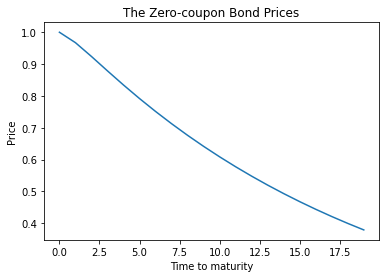

In [69]:
#T_plot1 = np.linspace(0.25,20,80)
#T_plot  = np.linspace(0.01,20,20)
T_plot=np.linspace(0.01,20,20)
# bond price
plot1 = P0(T_plot,my_r0,my_theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)
plt.plot(plot1)
plt.xlabel('Time to maturity')
plt.ylabel('Price')
plt.title('The Zero-coupon Bond Prices')

In [70]:
# yield curve
def y0(T,r0,theta0,phi,alpha,beta,sigma,eta):
    return 1/T * (B(0,T,alpha) * r0 + C(0,T,alpha,beta) * theta0 - A(0,T,phi,alpha,beta,sigma,eta))

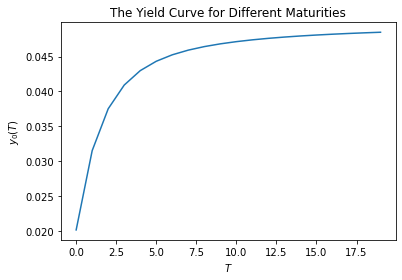

In [71]:
plot2=y0(T_plot,my_r0,my_theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)
plt.plot(plot2)
plt.xlabel("$T$")
plt.ylabel("$y_0(T)$")
plt.title('The Yield Curve for Different Maturities')
plt.show()

In [8]:
T_plot

array([1.00000000e-02, 1.06210526e+00, 2.11421053e+00, 3.16631579e+00,
       4.21842105e+00, 5.27052632e+00, 6.32263158e+00, 7.37473684e+00,
       8.42684211e+00, 9.47894737e+00, 1.05310526e+01, 1.15831579e+01,
       1.26352632e+01, 1.36873684e+01, 1.47394737e+01, 1.57915789e+01,
       1.68436842e+01, 1.78957895e+01, 1.89478947e+01, 2.00000000e+01])

## Q2

In [9]:
## bond price simulation, using Euler-Scheme
def bond_sim(r0,theta0,alpha,beta,phi,sigma,eta,T,Nsims,Ndt):
    f = np.zeros((len(T),2));
    for k in range(len(T)): #stepping through different maturities
        dt = T[k]/Ndt
        t  = np.linspace(0,T[k],Ndt)
        
        r  = np.zeros((Nsims,len(t)))
        theta = np.zeros((Nsims,len(t)))
 
        r[:,0] = r0
        theta[:,0] = theta0
        for i in range(len(t)-1):
            dw1          = np.sqrt(dt) * np.random.randn(Nsims) #under Q1
            dw2          = np.sqrt(dt) * np.random.randn(Nsims) #under Q2
            theta[:,i+1] = theta[:,i] + beta*(phi - theta[:,i])*dt + eta*dw2
            r[:,i+1]     = r[:,i] +  alpha*(theta[:,i] - r[:,i])*dt + sigma*dw1
           
        
        I = np.sum(r,axis=1)*dt # this is approximately equal to the integration of r_t term
 
        f[k,0] = np.mean(np.exp(-I))
        f[k,1] = np.std(np.exp(-I))/np.sqrt(Nsims)
    
    return f


In [10]:
my_T = np.linspace(1,10,20)

In [11]:
## simulation of bond prices using base parameters
psim = bond_sim(my_r0,my_theta0,my_alpha,my_beta,my_phi,my_sigma,my_eta,T_plot,Nsims,Ndt)

In [12]:
## simulation of yield
ysim = np.zeros(psim.shape)
ysim[:,0] = -np.log(psim[:,0])/T_plot
ysim[:,1] = -np.log(psim[:,0]+psim[:,1])/T_plot
ysim[:,1] = ysim[:,1] - ysim[:,0] 

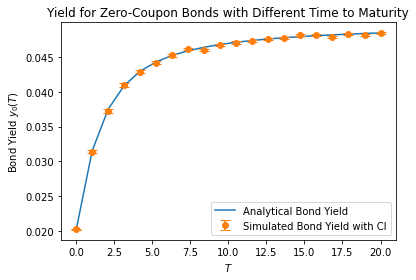

In [13]:
#version 1
plt.plot(T_plot,plot2)
plt.errorbar(T_plot, ysim[:,0],yerr=ysim[:,1],capsize=5,fmt="o")
plt.ylabel("Bond Yield $y_0(T)$")
plt.xlabel("$T$")
plt.legend([ "Analytical Bond Yield","Simulated Bond Yield with CI"]) 
plt.title("Yield for Zero-Coupon Bonds with Different Time to Maturity")
plt.show()

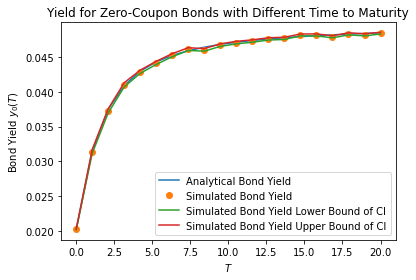

In [14]:
# version 2
plt.plot(T_plot,plot2)
plt.plot(T_plot,ysim[:,0],"o")
plt.plot(T_plot,ysim[:,0]+ysim[:,1])
plt.plot(T_plot,ysim[:,0]-ysim[:,1])
plt.legend([ "Analytical Bond Yield","Simulated Bond Yield","Simulated Bond Yield Lower Bound of CI",\
                                                               "Simulated Bond Yield Upper Bound of CI"])
plt.ylabel("Bond Yield $y_0(T)$")
plt.xlabel("$T$")
plt.title("Yield for Zero-Coupon Bonds with Different Time to Maturity")
plt.show()

## Q3 - Change parameters

In [15]:
def ysim_fun(psimx,T_plot):
    ysimx = np.zeros(psimx.shape)
    ysimx[:,0] = -np.log(psimx[:,0])/T_plot
    ysimx[:,1] = -np.log(psimx[:,0]+psimx[:,1])/T_plot
    ysimx[:,1] = ysimx[:,1] - ysimx[:,0] 
    return ysimx

#### Q3 - Change $\alpha$

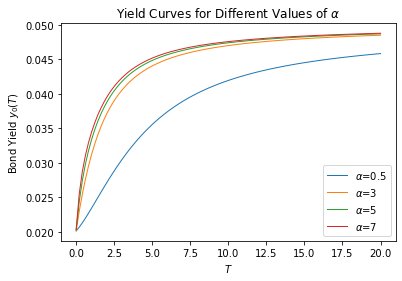

In [16]:
alpha_test=[0.5,3,5,7]
T_new=np.linspace(0.01,20,100)
plt.figure(figsize=(6,4))
for alpha in alpha_test:
    psim_alpha=bond_sim(my_r0,my_theta0,alpha,my_beta,my_phi,my_sigma,my_eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_alpha,T_new)
    plot_alpha=y0(T_new,my_r0,my_theta0,my_phi,alpha,my_beta,my_sigma,my_eta)
    plt.plot(T_new,plot_alpha,linewidth=1)
plt.legend(['$\u03B1$=0.5','$\u03B1$=3','$\u03B1$=5','$\u03B1$=7'])
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of $\u03B1$")
plt.show()


#### Q3 - Change $\beta$

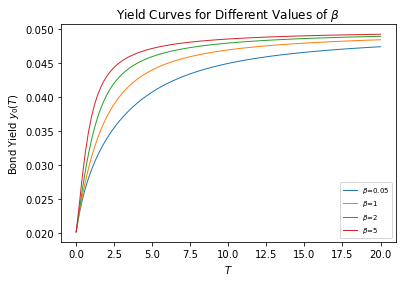

In [17]:
beta_test=[0.5,1,2,5]
T_new=np.linspace(0.01,20,100)
plt.figure(figsize=(6,4))
for beta in beta_test:
    psim_beta=bond_sim(my_r0,my_theta0,my_alpha,beta,my_phi,my_sigma,my_eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_beta,T_new)
    plot_beta=y0(T_new,my_r0,my_theta0,my_phi,my_alpha,beta,my_sigma,my_eta)
    plt.plot(T_new,plot_beta,linewidth=1)
plt.legend(['$\u03B2$=0.05','$\u03B2$=1','$\u03B2$=2','$\u03B2$=5'],fontsize=7)
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of $\u03B2$")
plt.show()


#### Q3 - Change $\phi$

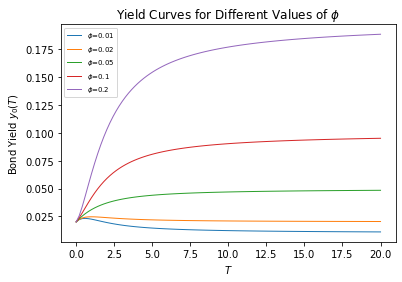

In [18]:
phi_test=[0.01,0.02,0.05,0.1,0.2]
T_new=np.linspace(0.01,20,100)
plt.figure(figsize=(6,4))
for phi in phi_test:
    psim_phi=bond_sim(my_r0,my_theta0,my_alpha,my_beta,phi,my_sigma,my_eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_phi,T_new)
    plot_phi=y0(T_new,my_r0,my_theta0,phi,my_alpha,my_beta,my_sigma,my_eta)
    plt.plot(T_new,plot_phi,linewidth=1)
plt.legend(['$\phi$=0.01','$\phi$=0.02','$\phi$=0.05','$\phi$=0.1','$\phi$=0.2'],fontsize=7)
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of $\phi$")
plt.show()


#### Q3-change current rate $r_0$

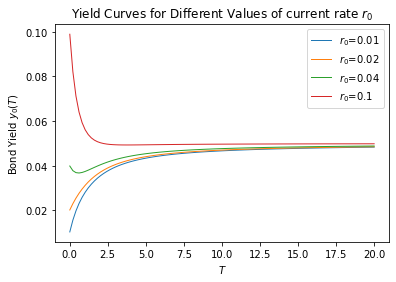

In [19]:
r_test=[0.01,0.02,0.04,0.1]
T_new=np.linspace(0.01,20,100)
plt.figure(figsize=(6,4))
for r in r_test:
    psim_r=bond_sim(r,my_theta0,my_alpha,my_beta,my_phi,my_sigma,my_eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_r,T_new)
    plot_r=y0(T_new,r,my_theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)
    plt.plot(T_new,plot_r,linewidth=1)
plt.legend(['$r_0$=0.01','$r_0$=0.02','$r_0$=0.04','$r_0$=0.1'])
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of current rate $r_0$")
plt.show()


#### change current rate $\theta_0$

In [20]:
my_theta0
from scipy.interpolate import make_interp_spline

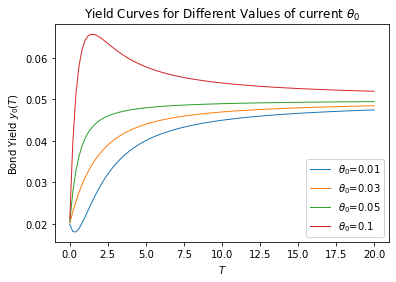

In [21]:
theta_test=[0.01,0.03,0.05,0.1]
plt.figure(figsize=(6,4))
for theta in theta_test:
    psim_theta=bond_sim(my_r0,theta,my_alpha,my_beta,my_phi,my_sigma,my_eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_theta,T_new)
    plot_theta=y0(T_new,my_r0,theta,my_phi,my_alpha,my_beta,my_sigma,my_eta)
    plt.plot(T_new,plot_theta,linewidth=1)
plt.legend(['$\u03B8_0$=0.01','$\u03B8_0$=0.03','$\u03B8_0$=0.05','$\u03B8_0$=0.1'])
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of current $\u03B8_0$")
plt.show()


#### Q3-Change $\eta_0$

In [22]:
my_eta

0.005

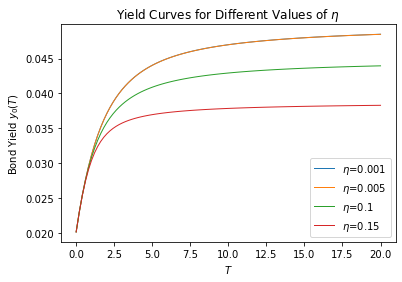

In [23]:
eta_test=[0.001,0.005,0.1,0.15]
plt.figure(figsize=(6,4))
for eta in eta_test:
    psim_eta=bond_sim(my_r0,my_theta0,my_alpha,my_beta,my_phi,my_sigma,eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_eta,T_new)
    plot_eta=y0(T_new,my_r0,my_theta0,my_phi,my_alpha,my_beta,my_sigma,eta)
    plt.plot(T_new,plot_eta,linewidth=1)
plt.legend(['$\u03B7$=0.001','$\u03B7$=0.005','$\u03B7$=0.1','$\u03B7$=0.15'],loc='lower right')
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of $\u03B7$")
plt.show()


#### Q3-change $\sigma$

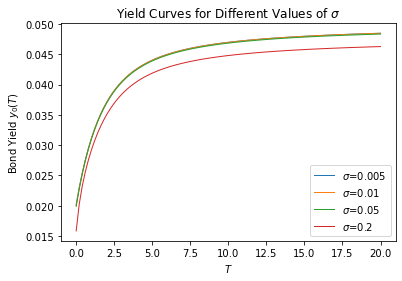

In [24]:
sigma_test=[0.005,0.01,0.05,0.2]
plt.figure(figsize=(6,4))
for sigma in sigma_test:
    psim_sigma=bond_sim(my_r0,my_theta0,my_alpha,my_beta,my_phi,sigma,my_eta,T_new,Nsims,Ndt)
    ysim=ysim_fun(psim_sigma,T_new)
    plot_sigma=y0(T_new,my_r0,my_theta0,my_phi,my_alpha,my_beta,sigma,my_eta)
    plt.plot(T_new,plot_sigma,linewidth=1)
plt.legend(['$\u03C3$=0.005','$\u03C3$=0.01','$\u03C3$=0.05','$\u03C3$=0.2'],loc='lower right')
plt.ylabel('Bond Yield $y_0(T)$')
plt.xlabel('$T$')
plt.title("Yield Curves for Different Values of $\u03C3$")
plt.show()


## Q4

In [25]:
np.arange(0.8, 1.25, 0.05)

array([0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 ])

In [26]:
def Bondsim2(T1,T2,r0, theta0, phi, alpha, beta, sigma, eta, Nsims, Ndt): # T1 < T2
    t=0
    T=np.append(T1,T2)
    a= np.arange(0.8, 1.25, 0.05)
    # Bond price at t=0 from analytical formula and Simulation
    P = P0(T[0],r0,theta0,phi,alpha,beta,sigma,eta)               #T1-maturity bond
    P=np.append(P,P0(T[1],r0,theta0,phi,alpha,beta,sigma,eta)) #P stores the values of P0(T1) and P0(T2)
    #print(P)
    V = np.zeros(len(a))
    Psim = np.zeros(2)
    Vsim = np.zeros(len(a))    
    #simulation
    for n in range(2):
        dt = (T1 + (T2-T1)*n) / Ndt   
        theta = np.zeros((Nsims, Ndt+1))
        theta[:,0] = theta0
        r = np.zeros((Nsims, Ndt+1))
        r[:,0] = r0
        for i in range(Ndt-1): 
            dw1= np.sqrt(dt)*np.random.randn(Nsims)
            dw2= np.sqrt(dt)*np.random.randn(Nsims)
            theta[:,i+1] = theta[:,i] + beta * (phi - theta[:,i]) * dt + eta * dw1
            r[:,i+1] = r[:,i] + alpha * (theta[:,i+1] - r[:,i]) * dt + sigma * dw2
        I = np.sum(r[:,:-1], axis=1) * dt         
        Psim[n] = np.mean(np.exp(-I))
     
    #print(Psim)
#analytical
    omega1 = sigma**2/(2*alpha**3) * \
             (np.exp(-alpha*T2) - np.exp(-alpha*T1))**2 *(np.exp(2*alpha*T1) - np.exp(2*alpha*t))
    part1= (np.exp(-beta*T2)-np.exp(-beta*T1))**2*(1/beta**2+1/(alpha-beta)**2+2/((alpha-beta)*beta))
    part2=(np.exp(-alpha*T2) - np.exp(-alpha*T1))**2/((alpha-beta)**2)
    part3=2*(np.exp(-alpha*T1) - np.exp(-alpha*T2))*(np.exp(-beta*T2) - np.exp(-beta*T1))* \
                (1/(alpha-beta)**2+1/((alpha-beta)*beta))
    omega2 = eta**2 * (1/(2*beta)*(np.exp(2*beta*T1) - np.exp(2*beta*t))*part1+ \
                    1/(2*alpha)*(np.exp(2*alpha*T1) - np.exp(2*alpha*t))*part2+\
                    1/(beta+alpha)*(np.exp((beta+alpha)*T1) - np.exp((beta+alpha)*t))*part3)
    
#analytical
    aplot =  np.arange(np.min(a)-0.1, np.max(a)+0.1, 0.001)
    Kplot =  aplot * (P[1] / P[0]) 
    
    Xt    = P[1] / P[0]  
    dp= ( np.log(Xt/Kplot) + 0.5*(omega1 + omega2) ) / np.sqrt(omega1 + omega2) 
    dm= ( np.log(Xt/Kplot) - 0.5*(omega1 + omega2) ) / np.sqrt(omega1 + omega2)
    V = P[0] * ( Xt * norm.cdf(dp) - Kplot * norm.cdf(dm))
    
#simulation
    for i in range(len(a)):
        K =  a[i] * (Psim[1] / Psim[0]) 
        Xt = Psim[1] / Psim[0]  
    
        dp= ( np.log(Xt/K) + 0.5*(omega1 + omega2) ) / np.sqrt(omega1 + omega2) 
        dm= ( np.log(Xt/K) - 0.5*(omega1 + omega2) ) / np.sqrt(omega1 + omega2)
        

        Vsim[i] = Psim[0] * ( Xt * norm.cdf(dp) - K * norm.cdf(dm) )
        print(Vsim[i])

        
    return P,V,Psim, Vsim, a, omega1, omega2,aplot
    #return omega1+omega2


In [885]:
Bondsim2(3,6,my_r0, my_theta0, my_phi, my_alpha, my_beta, my_sigma, my_eta, Nsims, Ndt)

0.15235885272084232
0.1142691395406317
0.07617942636042106
0.038089713180210434
0.0013357241829388671
1.8865418417368854e-32
2.2658970884172624e-108
3.712082629204136e-226
0.0


1.9316958599510557e-05

0.12500162713264273
0.09375122034948197
0.06250081356632131
0.031250406783160545
0.00014914423936663663
0.0
0.0
0.0
0.0


Text(0.5, 1.0, 'Bond Option Price with different Strike Price Scale')

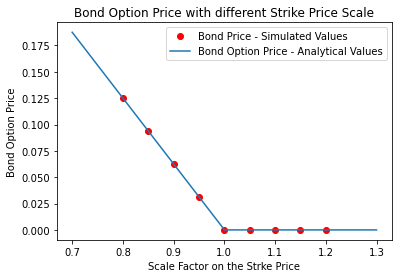

In [459]:
my_T1 = 0.01
my_T2 = 10
Px, Vx,Psimx, Vsimx, ax, omega1x, omega2x,aplotx = \
  Bondsim2(my_T1,my_T2, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)
plt.plot(ax, Vsimx,"o",color = "red")
plt.plot(aplotx, Vx)
plt.xlabel("Scale Factor on the Strke Price")
plt.ylabel("Bond Option Price")
plt.legend(["Bond Price - Simulated Values","Bond Option Price - Analytical Values",])
plt.title("Bond Option Price with different Strike Price Scale")

0.07553410594435729
0.05665057945826793
0.03776705297217862
0.018883526486089257
0.0006392639347807741
9.346083465557221e-35
3.5007570283893727e-116
1.501412407400584e-242
0.0
0.07553835102292723
0.056653763267195394
0.03776917551146355
0.018884587755731753
0.0007009679410671316
8.296562812437285e-30
1.246635440026696e-97
8.527082827109723e-203
0.0
0.07563139455302206
0.056723545914766554
0.03781569727651102
0.018907848638255474
0.000701817780175292
8.288660937926458e-30
1.2380101377652732e-97
8.389393552099195e-203
0.0
0.07546622155295175
0.05659966616471379
0.03773311077647582
0.01886655538823786
0.0006952117145517734
3.616917398410198e-30
5.586897752354959e-99
1.1023023649381158e-205
0.0
0.07536456062971027
0.0565234204722827
0.03768228031485511
0.01884114015742749
0.0004309944649069634
1.9522309142418986e-69
4.224605641789738e-247
0.0
0.0


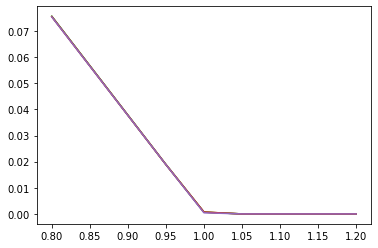

In [147]:
T1_1 = Bondsim2(1,20, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[3]
T1_5 = Bondsim2(5,20, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[3]
T1_10 = Bondsim2(10,20, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[3]
T1_15 = Bondsim2(15,20, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[3]
T1_19 = Bondsim2(19,20, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[3]
plt.plot(ax, T1_1)
plt.plot(ax, T1_5)
plt.plot(ax, T1_10)
plt.plot(ax, T1_15)
plt.plot(ax, T1_19)

0.16066289881934448
0.12049717411450836
0.08033144940967214
0.040165724704836016
0.0013324887784781126
1.2198905478279302e-35
2.0869205108864978e-120
5.563407568232255e-252
0.0
0.12464600749750043
0.09348450562312532
0.062323003748750216
0.031161501874375
0.0010547675956323007
1.5143544275693626e-34
5.393798162546703e-116
2.138711626758824e-242
0.0
0.09705966847413292
0.07279475135559965
0.0485298342370664
0.024264917118533146
0.000821439383873684
1.200804348265607e-34
4.4963307878208293e-116
1.9273839297032974e-242
0.0
0.0754506887163095
0.0565880165372321
0.037725344358154694
0.018862672179077295
0.0006385579540219752
9.335761976731212e-35
3.496890914616718e-116
1.4997542999843267e-242
0.0
0.058771676433503735
0.044078757325127796
0.029385838216751826
0.014692919108375859
0.0004973993256401107
7.272018899318459e-35
2.7238820576999474e-116
1.168228690344251e-242
0.0


Text(0.5, 1.0, 'Bond Option Price vs Strike Price Scale Factor @time t = 0 for Different T1 and T2 Selections')

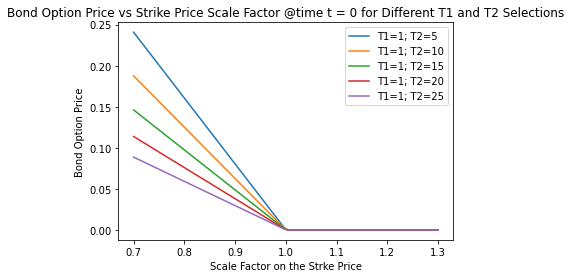

In [148]:
T2_5 = Bondsim2(1,5, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[1]
T2_10 = Bondsim2(1,10, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[1]
T2_15 = Bondsim2(1,15, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[1]
T2_20 = Bondsim2(1,20, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[1]
T2_25 = Bondsim2(1,25, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)[1]
plt.plot(aplotx, T2_5)
plt.plot(aplotx, T2_10)
plt.plot(aplotx, T2_15)
plt.plot(aplotx, T2_20)
plt.plot(aplotx, T2_25)
plt.xlabel("Scale Factor on the Strke Price")
plt.ylabel("Bond Option Price")
plt.legend(["T1=1; T2=5","T1=1; T2=10","T1=1; T2=15","T1=1; T2=20","T1=1; T2=25"])
plt.title("Bond Option Price vs Strike Price Scale Factor @time t = 0 for Different T1 and T2 Selections")

In [149]:
def Bondsim3(T1,T2,r0, theta0, phi, alpha, beta, sigma, eta, Nsims, Ndt): # T1 < T2
    t=0
    T=np.append(T1,T2)
    # Bond price at t=0 from analytical formula and Simulation
    P = P0(T[0],r0,theta0,phi,alpha,beta,sigma,eta)
    P=np.append(P,P0(T[1],r0,theta0,phi,alpha,beta,sigma,eta)) #P stores the values of P0(T1) and P0(T2)
    #print(P)
    delta_t = np.arange(0.1, T2-T1, 0.05)
    V = np.zeros(delta_t.shape)
    Psim = np.zeros(2)
    
    #simulation
    for n in range(2):
        dt = (T1 + (T2-T1)*n) / Ndt   
        theta = np.zeros((Nsims, Ndt+1))
        theta[:,0] = theta0
        r = np.zeros((Nsims, Ndt+1))
        r[:,0] = r0
        for i in range(Ndt-1): 
            dw1= np.sqrt(dt)*np.random.randn(Nsims)
            dw2= np.sqrt(dt)*np.random.randn(Nsims)
            theta[:,i+1] = theta[:,i] + beta * (phi - theta[:,i]) * dt + eta * dw1
            r[:,i+1] = r[:,i] + alpha * (theta[:,i+1] - r[:,i]) * dt + sigma * dw2
        I = np.sum(r[:,:-1], axis=1) * dt         
        Psim[n] = np.mean(np.exp(-I))
     
    
    omega1 = sigma**2/(2*alpha**3) * \
             (np.exp(-alpha*(T1+delta_t)) - np.exp(-alpha*T1))**2 *(np.exp(2*alpha*T1) - np.exp(2*alpha*t))
    part1= (np.exp(-beta*(T1+delta_t))-np.exp(-beta*T1))**2*(1/beta**2+1/(alpha-beta)**2+2/((alpha-beta)*beta))
    part2=(np.exp(-alpha*(T1+delta_t)) - np.exp(-alpha*T1))**2/((alpha-beta)**2)
    part3=2*(np.exp(-alpha*T1) - np.exp(-alpha*(T1+delta_t)))*(np.exp(-beta*(T1+delta_t)) - np.exp(-beta*T1))* \
                (1/(alpha-beta)**2+1/((alpha-beta)*beta))
    omega2 = eta**2 * (1/(2*beta)*(np.exp(2*beta*T1) - np.exp(2*beta*t))*part1+ \
                    1/(2*alpha)*(np.exp(2*alpha*T1) - np.exp(2*alpha*t))*part2+\
                    1/(beta+alpha)*(np.exp((beta+alpha)*T1) - np.exp((beta+alpha)*t))*part3)
#analytical
    K = (P[1] / P[0]) 
    print(K)
    Xt    = P[1] / P[0]  
    dp= ( np.log(Xt/K) + 0.5*(omega1 + omega2) ) / np.sqrt(omega1 + omega2) 
    dm= ( np.log(Xt/K) - 0.5*(omega1 + omega2) ) / np.sqrt(omega1 + omega2)
    V = P[0] * ( Xt * norm.cdf(dp) - K * norm.cdf(dm))

        
    return V, delta_t

0.6448004280017878


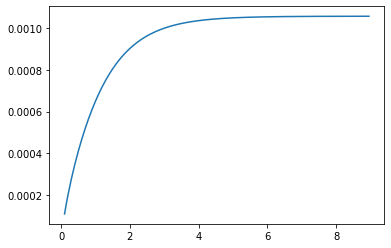

In [150]:
V1, delta_t1=Bondsim3(1,10, my_r0 , my_theta0, my_phi, my_alpha , my_beta, my_sigma, my_eta, Nsims, Ndt)
plt.plot(delta_t1,V1)

## Q5

In [28]:
my_tau = np.arange(3,6.25,0.25)

In [44]:
#Find the rate to make the sum 1

def check_r_star(T,tau,r,theta,phi,alpha,beta,sigma,eta,strike): #in this case T = tau[0] = 3

    sum_check = 0
    delta_tau = tau[1] - tau[0] ## in this case we use 0.25
    #print(delta_tau)
    #P_T_tau0  = np.exp(A(T,tau[0],phi,alpha,beta,sigma,eta) - B(T,tau[0],alpha) * r - C(T,tau[0],alpha,beta) * theta)
    A0 = 0
    for i in range(1,len(tau)): 
        A0 = A0+P0(tau[i],r,theta,phi,alpha,beta,sigma,eta)*0.25
        
    S0 = (P0(tau[0],r,theta,phi,alpha,beta,sigma,eta)-P0(tau[-1],r,theta,phi,alpha,beta,sigma,eta))/A0 
    K=S0*strike
    
    for i in range(1,len(tau)): # tau[0] is the reset date, we are not using it
        if i == len(tau) - 1:
            
            sum_check = sum_check +(1+ K* delta_tau) * \
                        np.exp(A(T,tau[i],phi,alpha,beta,sigma,eta) - B(T,tau[i],alpha) * r - C(T,tau[i],alpha,beta) * theta) 
        else:
            #P_star_temp = np.exp(A(T,tau[i],phi,alpha,beta,sigma,eta) - \
             #                      B(T,tau[i],alpha) * r - C(T,tau[i],alpha,beta) * theta)
            sum_check = sum_check + ( K * delta_tau) * \
            np.exp(A(T,tau[i],phi,alpha,beta,sigma,eta) - B(T,tau[i],alpha) * r - C(T,tau[i],alpha,beta) * theta)  
    
    return sum_check        
    #if abs(sum_check - 1) < 0.00001: return True
    #else: return False

In [45]:
check_r_star(3,my_tau,0.04,0.054,my_phi,my_alpha,my_beta,my_sigma,my_eta,1)

1.0000255911341203

In [46]:
r0 = 0.02
theta0 = 0.03

In [47]:
def sigma_calc(taui): #replace the previous formula with T2 = tau[i]; T1 = T
    t = 0
    omega1 = my_sigma**2/(2*my_alpha**3) * \
             (np.exp(-my_alpha*taui) - np.exp(-my_alpha*my_tau[0]))**2 *(np.exp(2*my_alpha*my_tau[0]) - np.exp(2*my_alpha*t))
    part1= (np.exp(-my_beta*taui)-np.exp(-my_beta*my_tau[0]))**2*(1/my_beta**2+1/(my_alpha-my_beta)**2+2/((my_alpha-my_beta)*my_beta))
    part2=(np.exp(-my_alpha*taui) - np.exp(-my_alpha*my_tau[0]))**2/((my_alpha-my_beta)**2)
    part3=2*(np.exp(-my_alpha*my_tau[0]) - np.exp(-my_alpha*taui))*(np.exp(-my_beta*taui) - np.exp(-my_beta*my_tau[0]))* \
                (1/(my_alpha-my_beta)**2+1/((my_alpha-my_beta)*my_beta))
    omega2 = my_eta**2 * (1/(2*my_beta)*(np.exp(2*my_beta*my_tau[0]) - np.exp(2*my_beta*t))*part1+ \
                    1/(2*my_alpha)*(np.exp(2*my_alpha*my_tau[0]) - np.exp(2*my_alpha*t))*part2+\
                    1/(my_beta+my_alpha)*(np.exp((my_beta+my_alpha)*my_tau[0]) - np.exp((my_beta+my_alpha)*t))*part3)
    return omega1+omega2

In [48]:
#current swap rate
A0=0
for i in range(1,len(my_tau)):
    A0 = A0+P0(my_tau[i],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)*0.25
        
S0 = (P0(my_tau[0],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)-P0(my_tau[-1],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta))/A0
S0

0.04980156741559877

In [49]:
def V_HW(scaler):
    v = 0
    X  = scaler * S0
    r_star=0.04
    #theta_guess=0.0
    
    def find_tstar(x):
            return check_r_star(my_tau[0],my_tau,r_star,x,my_phi, my_alpha , my_beta, my_sigma, my_eta,scaler)-1
    theta_star=fsolve(find_tstar,r_star)[0]
        
    def P_star(tau_k):
        return np.exp(A(my_tau[0],tau_k,my_phi, my_alpha , my_beta, my_sigma, my_eta) - \
                                   B(my_tau[0],tau_k,my_alpha) * r_star - C(my_tau[0],tau_k,my_alpha,my_beta) * theta_star)

    for i in range(1,len(my_tau)):
        SIGMA = sigma_calc(my_tau[i]) #sigma^2
    
        dplus  = np.log(P0(my_tau[i],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)/(\
                            P_star(my_tau[i])*P0(my_tau[0],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta))) + 1/2 * SIGMA
        dminus = np.log(P0(my_tau[i],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)/(\
                            P_star(my_tau[i])*P0(my_tau[0],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta))) - 1/2 * SIGMA
    
        dplus  = dplus/np.sqrt(SIGMA)
        dminus = dminus/np.sqrt(SIGMA)
    
        if i == len(my_tau) - 1:
            v+=(1+X*0.25)*(P_star(my_tau[i])*P0(my_tau[0],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)*norm.cdf(-dminus) -\
                                   P0(my_tau[i],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)*norm.cdf(-dplus))
        
        else:
            v+=(X*0.25)*(P_star(my_tau[i])*P0(my_tau[0],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)*norm.cdf(-dminus) -\
                                   P0(my_tau[i],r0,theta0,my_phi,my_alpha,my_beta,my_sigma,my_eta)*norm.cdf(-dplus))
    
    return v

In [50]:
V_HW(0.98)

0.002188881014054997

In [51]:
test=np.arange(0.96,1.02,0.01)
for i in test:
    print(V_HW(i))
    print(sim_HW(3,r1,theta1,my_tau,i,Nsims,500))
    print('--**--')

0.004177244356528927
0.005834485459576943
--**--
0.0031084222388679766
0.004607384349016504
--**--
0.002188881014054997
0.0035272931497866197
--**--
0.0014476616438380571
0.0026355668357072393
--**--
0.0008940079170894256
0.0019204269308098754
--**--
0.0005141533314489645
0.0012915602170188959
--**--
0.00027623127536560563
0.0008328218575874574
--**--


In [52]:
#simulate rate and theta
def simrate(r0,theta0,T,alpha, beta,phi,sigma,eta,Nsims, Ndt):
    dt = T / Ndt
    t = np.linspace(0, T, Ndt)
    r = np.zeros((Nsims, len(t)))
    theta = np.zeros((Nsims, len(t)))
    r[:,0] = r0
    theta[:,0] = theta0 
    
    for i in range(len(t)-1):

        dw1 = np.sqrt(dt) * np.random.randn(Nsims)
        dw2 = np.sqrt(dt) * np.random.randn(Nsims)
        theta[:,i+1] = theta[:,i] + beta * (phi - theta[:,i])*dt + eta*dw2
        r[:,i+1] = r[:,i] + alpha * (theta[:,i] - r[:,i])*dt + sigma*dw1
    
    return r, theta
    

In [53]:
## simulation of bond prices using base parameters
r1,theta1=simrate(r0,theta0,my_tau[0],my_alpha,my_beta,my_phi,my_sigma,my_eta,Nsims,Ndt)

In [54]:
r1[0,-1]

0.042697656412219155

In [55]:
def sim_HW(T,r,theta,tau,scaler,Nsims,Ndt):
    
    PT = np.zeros((Nsims,len(tau)-1))
    AT = np.zeros(Nsims)
    ST = np.zeros(Nsims)
    VT = np.zeros(Nsims)
    X = scaler *S0
    
    for i in range(Nsims):
        for j in range(len(tau)-1): 
            #bond price
            PT[i,j] = P0(tau[j+1]-tau[0],r[i,-1],theta[i,-1],my_phi,my_alpha,my_beta,my_sigma,my_eta)
        
        AT[i] = np.sum(PT[i,:],axis = 0)*0.25
        ST[i] = (1-PT[i,-1])/AT[i]
        VT[i]= AT[i]*max(ST[i]-X,0)
    V0 = np.mean(np.exp(-np.sum(r[:,:-1], axis=1)*(T/Ndt))*VT)
    
    return V0

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Black Impiled Volatility with two methods')

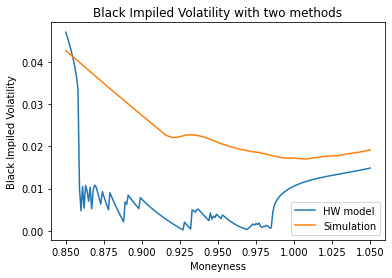

In [59]:
scaler=np.arange(0.85,1.05,0.001)

s_list=[]
vol_HW_list=[]
vol_sim_list=[]
starting_guess=0.05

for i in range(len(scaler)):
    k=scaler[i]
    v_hw=V_HW(k)
    v_sim=sim_HW(3,r1,theta1,my_tau,k,Nsims,Ndt)
    X=S0*k
    
    def V_LSM_root(OMEGA):
        dplus = (np.log(1/k)+0.5*(OMEGA**2)*my_tau[0])/(OMEGA*np.sqrt(my_tau[0]))
        dminus = (np.log(1/k)-0.5*(OMEGA**2)*my_tau[0])/(OMEGA*np.sqrt(my_tau[0]))
        return A0*(S0*norm.cdf(dplus)-X*norm.cdf(dminus))-v_hw
    
    def V_SIM_root(OMEGA):
        dplus = (np.log(1/k)+0.5*(OMEGA**2)*my_tau[0])/(OMEGA*np.sqrt(my_tau[0]))
        dminus = (np.log(1/k)-0.5*(OMEGA**2)*my_tau[0])/(OMEGA*np.sqrt(my_tau[0]))
        return A0*(S0*norm.cdf(dplus)-X*norm.cdf(dminus))-v_sim
    
    
    vol_HW_list.append(fsolve(V_LSM_root, starting_guess))
    vol_sim_list.append(fsolve(V_SIM_root, starting_guess))

plt.plot(scaler,vol_HW_list)
plt.plot(scaler,vol_sim_list)
plt.legend(['HW model','Simulation'],loc='lower right')
plt.xlabel('Moneyness')
plt.ylabel('Black Impiled Volatility')
plt.title('Black Impiled Volatility with two methods')
    

In [60]:
def V_LSM(scaler, omega,T,t):
    d1  = (np.log(1/scaler)+0.5*(omega**2)*(T-t))/(omega*np.sqrt(T-t))
    d2  =(np.log(1/scaler)-0.5*(omega**2)*(T-t))/(omega*np.sqrt(T-t))
    return A0*(S0*norm.cdf(d1)-scaler*S0*norm.cdf(d2))
    

In [61]:
def LSM_vega(scaler, omega,T,t):
    d1  = (np.log(1/scaler)+0.5*(omega**2)*(T-t))/(omega*np.sqrt(T-t))
    return A0*S0* norm.pdf(d1)*np.sqrt(T-t)

In [62]:
def find_vol(first_guess,target_value, scaler, T, t,*args):
    MAX_ITERATIONS = 5000
    PRECISION = 1.0e-20
    omega = first_guess
    for i in range(0, MAX_ITERATIONS):
        price = V_LSM(scaler,omega,T,t)
        vega = LSM_vega(scaler, omega, T,t)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return omega
        omega += diff/vega # f(x) / f'(x)
    return omega # value wasn't found, return best guess so far

Text(0.5, 1.0, 'Black Implied Volatitliy Skew')

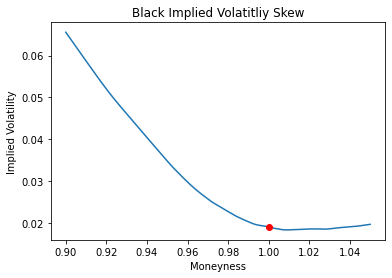

In [65]:
scaler1=np.arange(0.9,1.05,0.001)

vol_HW_list=[]
vol_sim_list=[]

#starting_guess=0.02

for k in scaler1:
    #target=V_HM(k)
    target1=sim_HW(3,r1,theta1,my_tau,k,Nsims,500)
    #target=V_HM(k)
    first_guess=0.03

    vol_sim_list.append(find_vol(first_guess,target1,k,3,0))
target=sim_HW(3,r1,theta1,my_tau,1,Nsims,500)
atm=find_vol(0.02,target,1,3,0)

plt.plot(scaler1,vol_sim_list)
plt.plot(1,atm,'o',color='red')
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Black Implied Volatitliy Skew')
  